# An adaptive ensemble framework for addressing concept drift in IoT data streams
This is the code for the paper entitled "**An adaptive ensemble framework for addressing concept drift in IoT data streams**"   <br>
Authors: Yafeng Wu (neverland0504@163.com), Lan Liu (liulan@gpnu.edu.cn), Yongjie Yu, Guiming Chen, Junhan Hu  <br>
Organization: School of Cybersecurity and Information Engineering, Guangdong Polytechnic Normal University


# 1. Load Data and Define Functions

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install river==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.6/848.6 kB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for river: filename=river-0.10.1-cp310-cp310-linux_x86_64.whl size=2102619 sha256=f59e96c4d6b0f8b392f637dd970b9d5fee12430fcc66840cf743583602b499d3
  Stored in directory: /root/.cache/pip/wheels/ca/8e/67/2a975aa30c8517b43e5e03cff2f523a9c659688afe5f21e407
Successfully built river


In [ ]:
!pip install optunity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 67.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72030 sha256=35d21ab6950918f9a62396b0ed74a5209109007f58231b043587dc5790a62b07
  Stored in directory: /root/.cache/pip/wheels/83/98/40/b9956c3386a045f035f9edbf894edd04713db92f29fb58a225
Successfully built optunity


In [ ]:
!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep 'MemTotal'

model name	: AMD EPYC 7B12
model name	: AMD EPYC 7B12
MemTotal:       13294256 kB


## Dataset 1: CICIDS2017
A subset of the network traffic data randomly sampled from the [CICIDS2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html). And then normalized by Z-score.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/AEWAE/Data/cic_0.005km_78.csv")
# df = df.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
# df = df.sort_index()

In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.439347,-0.009819,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
1,-0.438645,0.024863,0.021663,-0.038155,0.018451,-0.281099,-0.210703,-0.280518,-0.245069,1.040477,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
2,-0.435103,0.052875,0.048734,0.077620,0.038987,0.505309,-0.310140,-0.167451,0.139355,1.784427,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
3,-0.259461,-0.008485,-0.009418,-0.053765,-0.007142,-0.281099,-0.310140,-0.291266,-0.232749,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
4,-0.439342,-0.009819,-0.008416,-0.047961,-0.007097,-0.240663,0.269913,-0.124680,-0.245069,-0.421220,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14150,-0.437855,-0.009819,-0.008416,-0.048762,-0.007034,-0.246240,0.203621,-0.146175,-0.245069,-0.384742,...,0.002564,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
14151,-0.439341,-0.009819,-0.008416,-0.046160,-0.007059,-0.228114,0.419069,-0.076317,-0.245069,-0.399128,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
14152,-0.439343,-0.009819,-0.008416,-0.037754,-0.007023,-0.169552,1.115132,0.149379,-0.245069,-0.378577,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
14153,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0


In [ ]:
print(df['Label'].value_counts())

0    11457
1     2698
Name: Label, dtype: int64


## Train-test split
10% training set, and 90% test set

In [ ]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

## Define Functions

In [ ]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley

In [ ]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    eddm = EDDM()

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy

        #drift_detection part
        val = 0
        if yi != y_pred:
            val = 1
        in_drift, in_warning = eddm.update(float(val))
        if in_drift:
            print(f"Change detected at index {i}")

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [ ]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on CICIDS2017 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

# 2.AEWAE method Development

## Define the AEWAE method

In [ ]:
def AEWAE(X_train, y_train, X_test, y_test, alpha):
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    cumulative_error1 = 0
    cumulative_error2 = 0
    cumulative_error3 = 0
    cumulative_error4 = 0

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
    hat4 = linear_model.PAClassifier() # OPA

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)

        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        error1 = 1 if y_pred1 != yi else 0
        error2 = 1 if y_pred2 != yi else 0
        error3 = 1 if y_pred3 != yi else 0
        error4 = 1 if y_pred4 != yi else 0

        cumulative_error1 = alpha * cumulative_error1 + (1 - alpha) * error1
        cumulative_error2 = alpha * cumulative_error2 + (1 - alpha) * error2
        cumulative_error3 = alpha * cumulative_error3 + (1 - alpha) * error3
        cumulative_error4 = alpha * cumulative_error4 + (1 - alpha) * error4

        ewa_error_rate1 = cumulative_error1 / (1 - alpha ** (i + 1))
        ewa_error_rate2 = cumulative_error2 / (1 - alpha ** (i + 1))
        ewa_error_rate3 = cumulative_error3 / (1 - alpha ** (i + 1))
        ewa_error_rate4 = cumulative_error4 / (1 - alpha ** (i + 1))

        # Calculating the weights of base classifiers
        ep = 0.001
        ea = 1 / (ewa_error_rate1 + ep) + 1 / (ewa_error_rate2 + ep) + 1 / (ewa_error_rate3 + ep) + 1 / (
                ewa_error_rate4 + ep)
        w1 = 1 / (ewa_error_rate1 + ep) / ea
        w2 = 1 / (ewa_error_rate2 + ep) / ea
        w3 = 1 / (ewa_error_rate3 + ep) / ea
        w4 = 1 / (ewa_error_rate4 + ep) / ea

        # Calculating the probabilities of each class
        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)

        # Calculate the final probability and make a prediction
        y_prob_0 = w1 * ypro10 + w2 * ypro20 + w3 * ypro30 + w4 * ypro40
        y_prob_1 = w1 * ypro11 + w2 * ypro21 + w3 * ypro31 + w4 * ypro41

        if y_prob_0 > y_prob_1:
            y_pred = 0
        else:
            y_pred = 1

        # Updating the real-time accuracy of the overall model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)

        i = i + 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")

    return t, m

## Hyperparameter optimization by BO-TPE

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
def aewae_bo(params):
    alpha = params['alpha']
    t, m = AEWAE(X_train, y_train, X_test, y_test, alpha)


    accuracy = m[-1] / 100
    print(f"Alpha: {alpha}, Accuracy: {accuracy * 100}%")
    return {'loss': -accuracy, 'status': STATUS_OK}


In [ ]:
space = {
    'alpha': hp.uniform('alpha', 0.01, 1.0),
}
t1 = time.time()
best = fmin(
    fn=aewae_bo,
    space=space,
    algo=tpe.suggest,
    max_evals=10
)
print("Hyperopt estimated optimum {}".format(best))
t2 = time.time()
print(t2 - t1)


Accuracy: 99.68%
Precision: 99.61%
Recall: 98.42999999999999%
F1-score: 99.02%
Alpha: 0.6485494366147158, Accuracy: 99.67817896389325%
Accuracy: 99.61%
Precision: 99.33%
Recall: 98.28%
F1-score: 98.8%
Alpha: 0.2505037047547036, Accuracy: 99.60753532182103%
Accuracy: 99.58%
Precision: 99.37%
Recall: 98.05%
F1-score: 98.7%
Alpha: 0.7907537035495503, Accuracy: 99.57613814756672%
Accuracy: 99.62%
Precision: 99.37%
Recall: 98.28%
F1-score: 98.83%
Alpha: 0.40787537176387767, Accuracy: 99.61538461538461%
Accuracy: 99.44%
Precision: 99.03%
Recall: 97.57000000000001%
F1-score: 98.3%
Alpha: 0.9140782916501061, Accuracy: 99.44270015698588%
Accuracy: 99.65%
Precision: 99.71%
Recall: 98.14%
F1-score: 98.92%
Alpha: 0.7109179880178805, Accuracy: 99.64678178963892%
Accuracy: 99.53999999999999%
Precision: 99.18%
Recall: 98.0%
F1-score: 98.59%
Alpha: 0.9277135336004192, Accuracy: 99.53689167974882%
Accuracy: 99.61%
Precision: 99.47%
Recall: 98.14%
F1-score: 98.8%
Alpha: 0.44393048536236335, Accuracy: 99

## Hyperparameter optimization by PSO

In [ ]:
def AEWAE_alpha_optimization(X_train, y_train, X_test, y_test, alpha):
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    cumulative_error1 = 0
    cumulative_error2 = 0
    cumulative_error3 = 0
    cumulative_error4 = 0

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
    hat4 = linear_model.PAClassifier() # OPA

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)

        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        error1 = 1 if y_pred1 != yi else 0
        error2 = 1 if y_pred2 != yi else 0
        error3 = 1 if y_pred3 != yi else 0
        error4 = 1 if y_pred4 != yi else 0

        cumulative_error1 = alpha * cumulative_error1 + (1 - alpha) * error1
        cumulative_error2 = alpha * cumulative_error2 + (1 - alpha) * error2
        cumulative_error3 = alpha * cumulative_error3 + (1 - alpha) * error3
        cumulative_error4 = alpha * cumulative_error4 + (1 - alpha) * error4

        ewa_error_rate1 = cumulative_error1 / (1 - alpha ** (i + 1))
        ewa_error_rate2 = cumulative_error2 / (1 - alpha ** (i + 1))
        ewa_error_rate3 = cumulative_error3 / (1 - alpha ** (i + 1))
        ewa_error_rate4 = cumulative_error4 / (1 - alpha ** (i + 1))


        ep = 0.001
        ea = 1 / (ewa_error_rate1 + ep) + 1 / (ewa_error_rate2 + ep) + 1 / (ewa_error_rate3 + ep) + 1 / (
                ewa_error_rate4 + ep)
        w1 = 1 / (ewa_error_rate1 + ep) / ea
        w2 = 1 / (ewa_error_rate2 + ep) / ea
        w3 = 1 / (ewa_error_rate3 + ep) / ea
        w4 = 1 / (ewa_error_rate4 + ep) / ea


        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)


        y_prob_0 = w1 * ypro10 + w2 * ypro20 + w3 * ypro30 + w4 * ypro40
        y_prob_1 = w1 * ypro11 + w2 * ypro21 + w3 * ypro31 + w4 * ypro41

        if y_prob_0 > y_prob_1:
            y_pred = 0
        else:
            y_pred = 1


        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)

        i = i + 1

    return metric.get()



In [ ]:
def optimize_AEWAE(alpha):
    return AEWAE_alpha_optimization( X_train, y_train, X_test, y_test, alpha)

In [ ]:
import optunity
import optunity.metrics
search = {
    'alpha': [0.01, 0.99],
}


optimal_configuration, info, _ = optunity.maximize(optimize_AEWAE,
                                                   solver_name='particle swarm',
                                                   num_evals=10,
                                                   **search
                                                  )

print(optimal_configuration)
print("Accuracy: " + str(info.optimum))

{'alpha': 0.032490234375}
Accuracy: 0.9970172684458398


# 3.Model Learning

## Base Model Learning for Comparison Purposes
State-of-the-art online learning models:
* Adaptive Random Forest (ARF) model with ADWIN drift detector (ARF-ADWIN)
* Adaptive Random Forest (ARF) model with EDDM drift detector (ARF-EDDM)
* Online Passive-Aggressive (OPA)
* Streaming Random Patches (SRP)
* K-Nearest Neighbors (KNN) classifier with ADWIN change detector (KNN-ADWIN)
* Hoeffding Tree (HT)
* Hierarchical Attentive Temporal Memory(HATT)
* Performance Weighted Probability Averaging Ensemble (PWPAE)
  * Proposed by LiYang
* Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)
  * Proposed by LiYang
* Adaptive Exponentially Weighted Ensemble(AEWAE)
  * Proposed


Change detected at index 6428
Change detected at index 8072
Change detected at index 9756
Change detected at index 11096
Change detected at index 12097
Accuracy: 98.56%
Precision: 96.41%
Recall: 94.76%
F1-score: 95.58%
CPU times: user 13.1 s, sys: 119 ms, total: 13.2 s
Wall time: 13.2 s


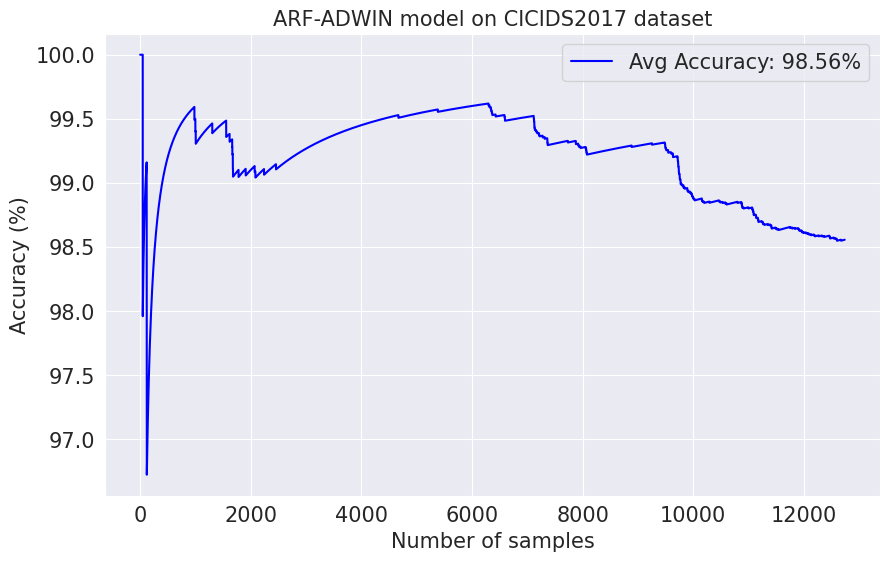

In [ ]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 6633
Change detected at index 7317
Change detected at index 9496
Change detected at index 11025
Accuracy: 98.74000000000001%
Precision: 97.97%
Recall: 94.28%
F1-score: 96.09%
CPU times: user 13.2 s, sys: 134 ms, total: 13.4 s
Wall time: 14.3 s


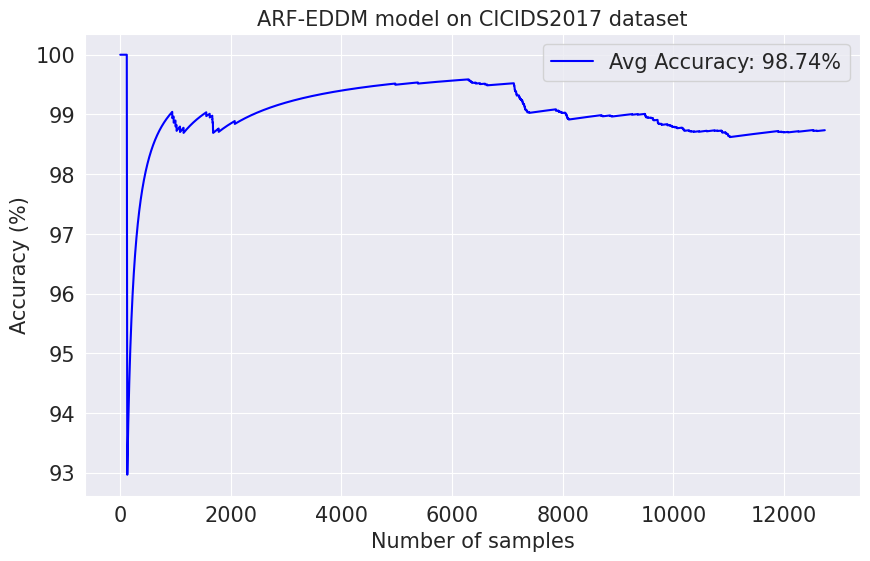

In [ ]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name2 = "ARF-EDDM"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 6588
Change detected at index 8024
Change detected at index 9634
Change detected at index 10881
Accuracy: 98.56%
Precision: 95.44%
Recall: 95.81%
F1-score: 95.62%
CPU times: user 2.36 s, sys: 182 ms, total: 2.54 s
Wall time: 2.42 s


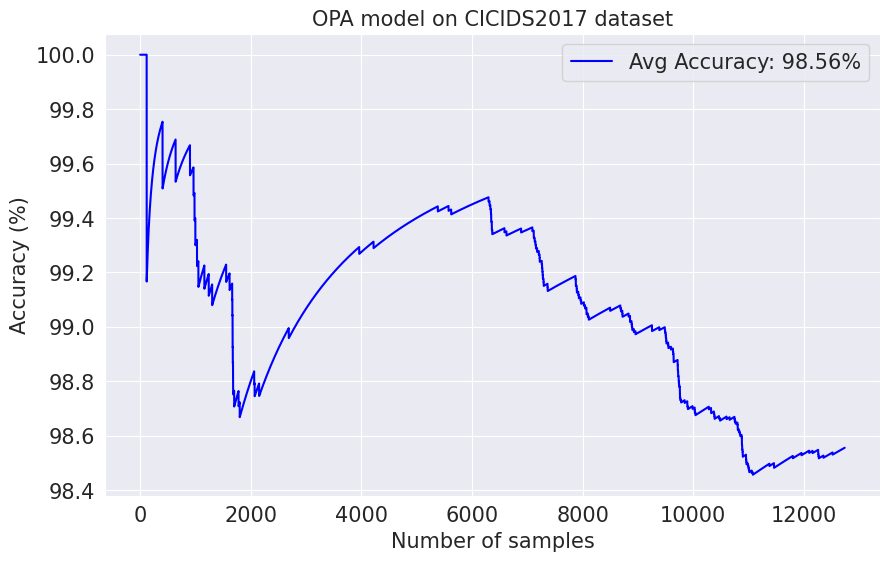

In [ ]:
%%time
# Use the Online Passive-Aggressive (OPA) model
name3 = "OPA"
model3 = linear_model.PAClassifier() # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 5277
Change detected at index 7879
Change detected at index 9738
Change detected at index 11029
Accuracy: 98.82%
Precision: 96.96000000000001%
Recall: 95.85000000000001%
F1-score: 96.39999999999999%
CPU times: user 1min 40s, sys: 322 ms, total: 1min 41s
Wall time: 1min 41s


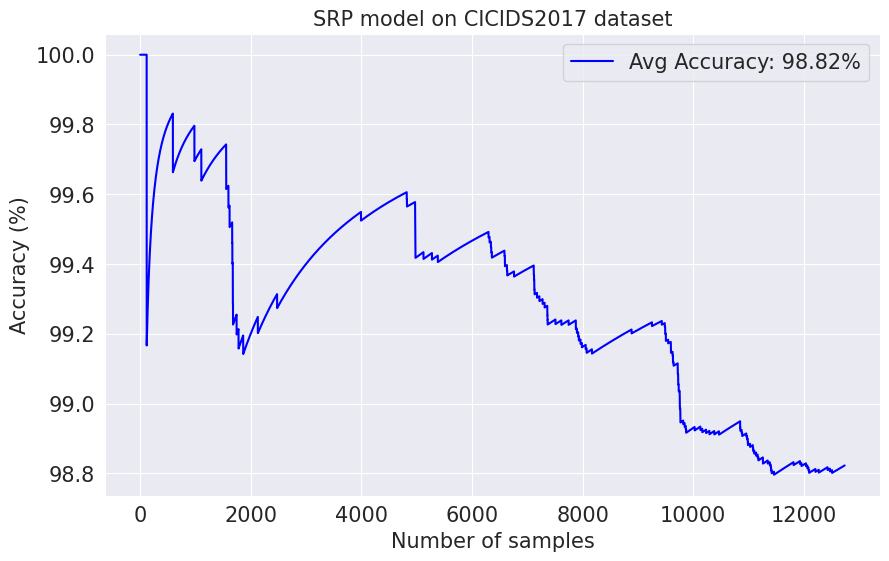

In [ ]:
%%time
# Use the Streaming Random Patches (SRP) model
name4 = "SRP"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 966
Change detected at index 7220
Change detected at index 9686
Change detected at index 10915
Accuracy: 98.57000000000001%
Precision: 94.6%
Recall: 96.85000000000001%
F1-score: 95.71%
CPU times: user 8.11 s, sys: 78.7 ms, total: 8.19 s
Wall time: 8.24 s


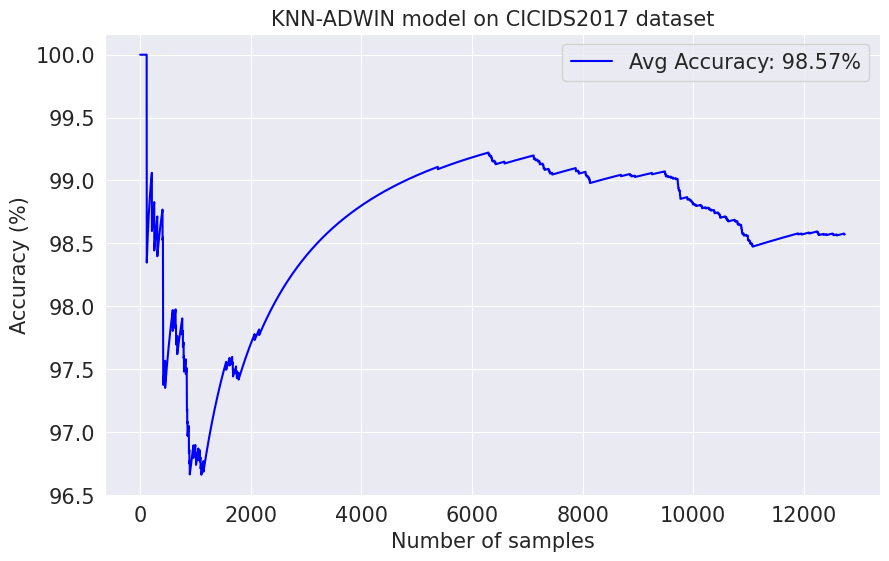

In [ ]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name5 = "KNN-ADWIN"
model5 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 868
Change detected at index 1034
Change detected at index 1204
Change detected at index 1721
Change detected at index 1796
Change detected at index 1965
Change detected at index 2033
Change detected at index 2138
Change detected at index 2229
Change detected at index 2389
Change detected at index 2492
Change detected at index 2584
Change detected at index 2677
Change detected at index 2773
Change detected at index 7128
Change detected at index 7335
Change detected at index 9513
Change detected at index 9732
Change detected at index 9777
Change detected at index 9838
Change detected at index 9887
Change detected at index 10244
Change detected at index 10383
Change detected at index 10943
Change detected at index 12097
Change detected at index 12604
Accuracy: 90.48%
Precision: 69.91000000000001%
Recall: 74.07000000000001%
F1-score: 71.93%
CPU times: user 11.7 s, sys: 127 ms, total: 11.8 s
Wall time: 11.9 s


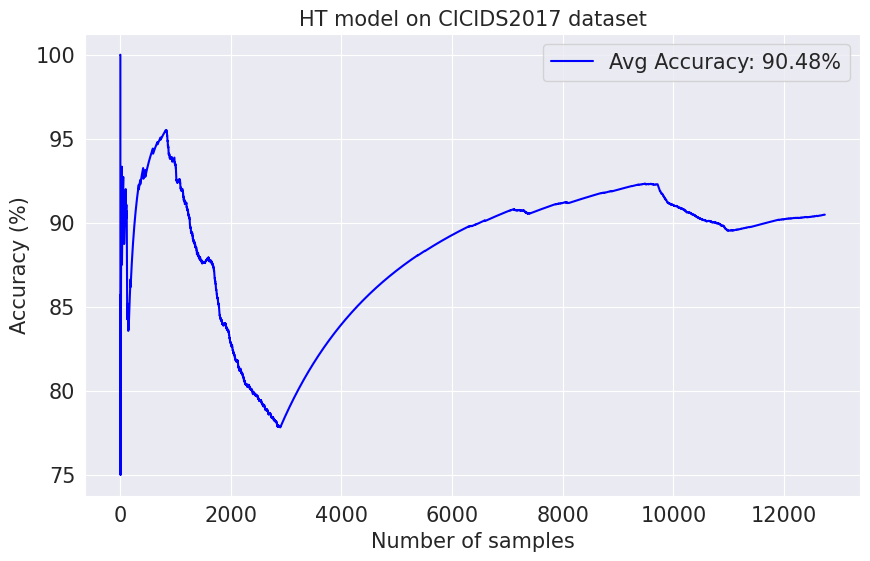

In [ ]:
%%time
# Use the HoeffdingTree model
name6 = "HT"
model6 = tree.HoeffdingTreeClassifier() # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 872
Change detected at index 1034
Change detected at index 1175
Change detected at index 1701
Change detected at index 6597
Change detected at index 7364
Change detected at index 9547
Change detected at index 9729
Change detected at index 10966
Change detected at index 12217
Accuracy: 95.67999999999999%
Precision: 85.5%
Recall: 88.8%
F1-score: 87.12%
CPU times: user 27.3 s, sys: 167 ms, total: 27.5 s
Wall time: 27.7 s


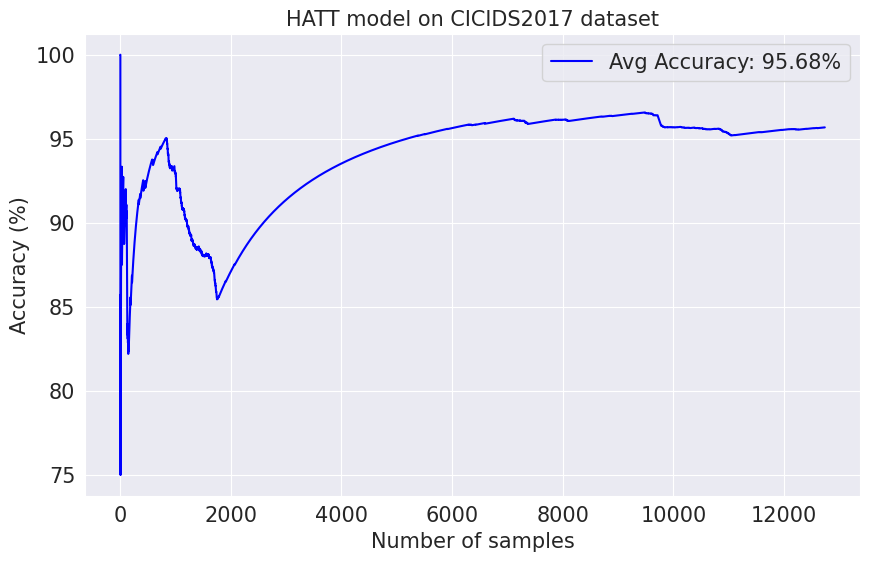

In [ ]:
%%time
# Use the HoeffdingAdaptiveTree model
name7 = "HATT"
model7 = tree.HoeffdingAdaptiveTreeClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=3) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    # The four base learners learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        y_pred1= hat1.predict_one(xi)
        y_prob1= hat1.predict_proba_one(xi) #y_prob1记录模型1预测的概率，类似(0.95,0.1)
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi)
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi)
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi)
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)

        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()


        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)



        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1

        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)

        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 99.14%
Precision: 98.77%
Recall: 95.95%
F1-score: 97.34%
CPU times: user 4min 29s, sys: 638 ms, total: 4min 29s
Wall time: 4min 32s


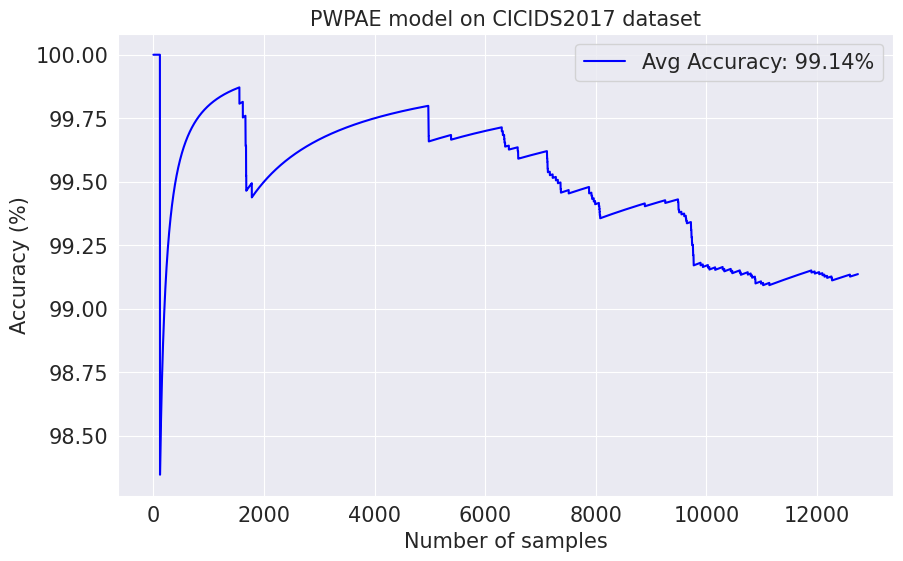

In [ ]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model
name8 = "PWPAE"
t, m8 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m8, name8) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
# Define the Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE) model
# An extension method of the PWPAE model
from river import feature_selection
from river import stats
def MSANA(model1, model2, model3, model4, X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    metric_w1 = []
    metric_w2 = []
    metric_w3 = []
    metric_w4 = []


    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = model1
    hat2 = model2
    hat3 = model3
    hat4 = model4

    # Define the two feature selections methods: Variance Threshold and Select-K-Best
    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)

    # Use EDDM to detect concept drift, it can be replaced with other drift detection methods like ADWIN, DDM, etc.
    eddm = EDDM()
    drift = 0

    # Initial feature selection on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1)

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1)

    # Train the online models on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learners predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi)
        y_prob1= hat1.predict_proba_one(xi)
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi)
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi)
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi)
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)

        if y_pred1 == yi:
            metric_w1.append(0)
        else:
            metric_w1.append(1)
        if y_pred2 == yi:
            metric_w2.append(0)
        else:
            metric_w2.append(1)
        if y_pred3 == yi:
            metric_w3.append(0)
        else:
            metric_w3.append(1)
        if y_pred4 == yi:
            metric_w4.append(0)
        else:
            metric_w4.append(1)

        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)


        # Calculate the real-time window error rates of four base learners
        if i<1000:
            e1 = 0
            e2 = 0
            e3 = 0
            e4 = 0
        else:
            e1 = sum(metric_w1[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e2 = sum(metric_w2[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e3 = sum(metric_w3[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e4 = sum(metric_w4[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])


        ep = 0.001 # The epsilon used to avoid dividing by 0

        # Calculate the weight of each base learner by the reciprocal of its window real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

#         print(str(i)+" "+str(w1)+" "+str(w2)+" "+str(w3)+" "+str(w4)+" "+str(y_prob_0)+" "+str(y_prob_1))

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1

        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        # Detect concept drift
        val = 0
        if yi != y_pred:
            val = 1
        in_drift, in_warning = eddm.update(float(val))

        if in_drift & (i>1000) :
            print(f"Change detected at index {i}")
            drift = 1 # indicating that a drift occurs

        # If a drift is detected
        if drift == 1:
            x_new = X_test[round(0.9*i):i]
            y_new = y_test[round(0.9*i):i]

            # Relearn the online models on the most recent window data (representing new concept data)
            hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            hat2 = neighbors.KNNADWINClassifier(window_size=100)
            hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            hat4 = linear_model.PAClassifier() # SRP-DDM

            # Re-select features
            selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
            selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)

            for xj, yj in stream.iter_pandas(x_new, y_new):
                selector1 = selector1.learn_one(xj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                selector2 = selector2.learn_one(xj, yj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                xa = selector2.transform_one(xj)
                hat1.learn_one(xa,yj)
                hat2.learn_one(xa,yj)
                hat3.learn_one(xa,yj)
                hat4.learn_one(xa,yj)

                if j ==1:
                    print(len(xa))
                    j=0
            drift = 0

        j=1


        t.append(i)
        m.append(metric.get()*100)

        yt.append(yi)
        yp.append(y_pred)

        i=i+1

    # outputs
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    print(metric1.get()*100)
    print(metric2.get()*100)
    print(metric3.get()*100)
    print(metric4.get()*100)
    return t, m

Change detected at index 7220
40
Change detected at index 9728
40
Change detected at index 10961
40
Accuracy: 99.09%
Precision: 97.69%
Recall: 96.76%
F1-score: 97.22%
98.28885400313972
98.67346938775509
98.17111459968602
98.38304552590267
CPU times: user 58.8 s, sys: 220 ms, total: 59 s
Wall time: 1min 5s


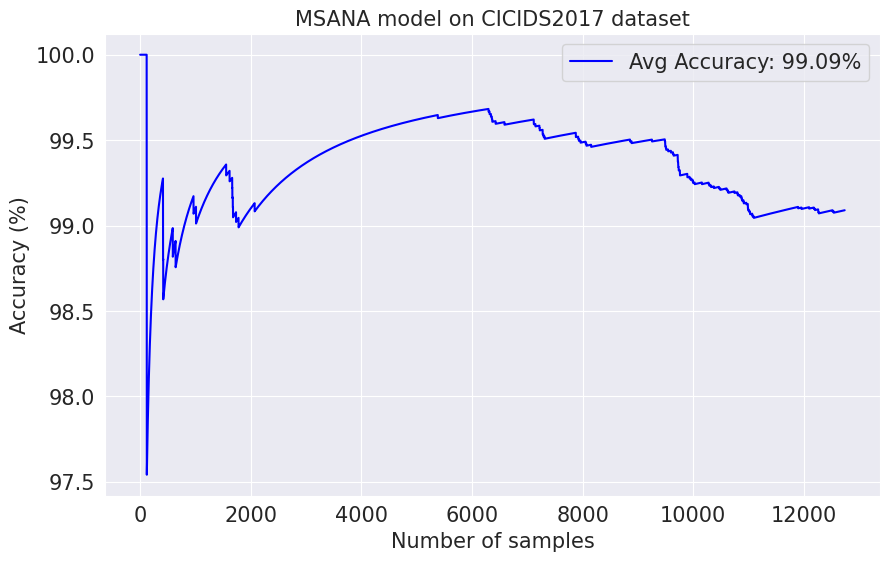

In [ ]:
%%time
# Use the Multi-Stage Automated Network Analytics (MSANA) model

# Select the four base online models, they can be changed based on the performance of the models
bm1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
bm2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
bm3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
bm4 = linear_model.PAClassifier() # OPA

name9 = "MSANA"
t, m9 = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m9, name9) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.69%
Precision: 99.81%
Recall: 98.28%
F1-score: 99.03999999999999%
CPU times: user 48.5 s, sys: 166 ms, total: 48.7 s
Wall time: 49.1 s


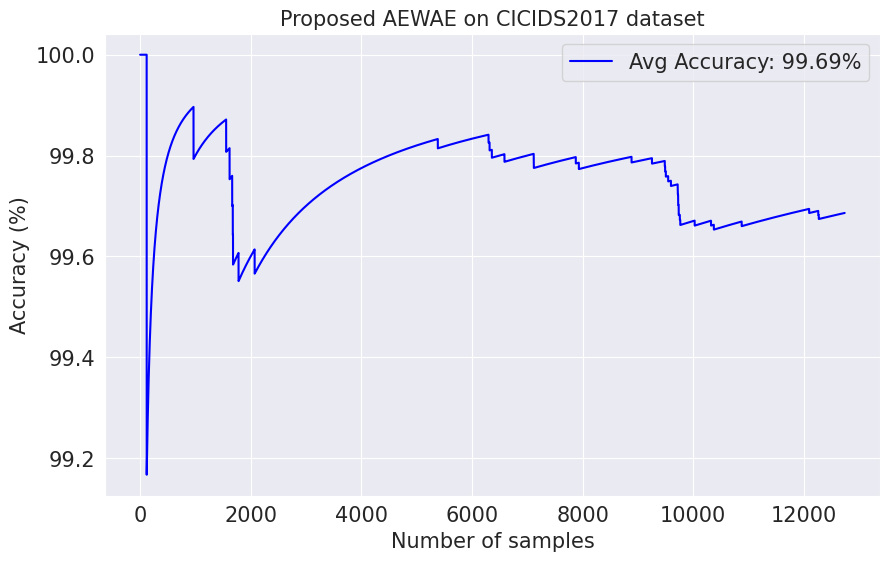

In [ ]:
%%time
# proposed Adaptive Exponentially Weighted Average Ensemble (AEWAE) model
name = "Proposed AEWAE"
t, m = AEWAE(X_train, y_train, X_test, y_test, 0.032490234375) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

### Model comparison

In [ ]:
name = "Proposed AEWAE"
name1 = "ARF-ADWIN"
name2 = "ARF-EDDM"
name3 = "OPA"
name4 = "SRP"
name5 = "KNN-ADWIN"
name6 = "HT"
name7 = "HATT"
name8 = "PWPAE"
name9 = "MSANA"

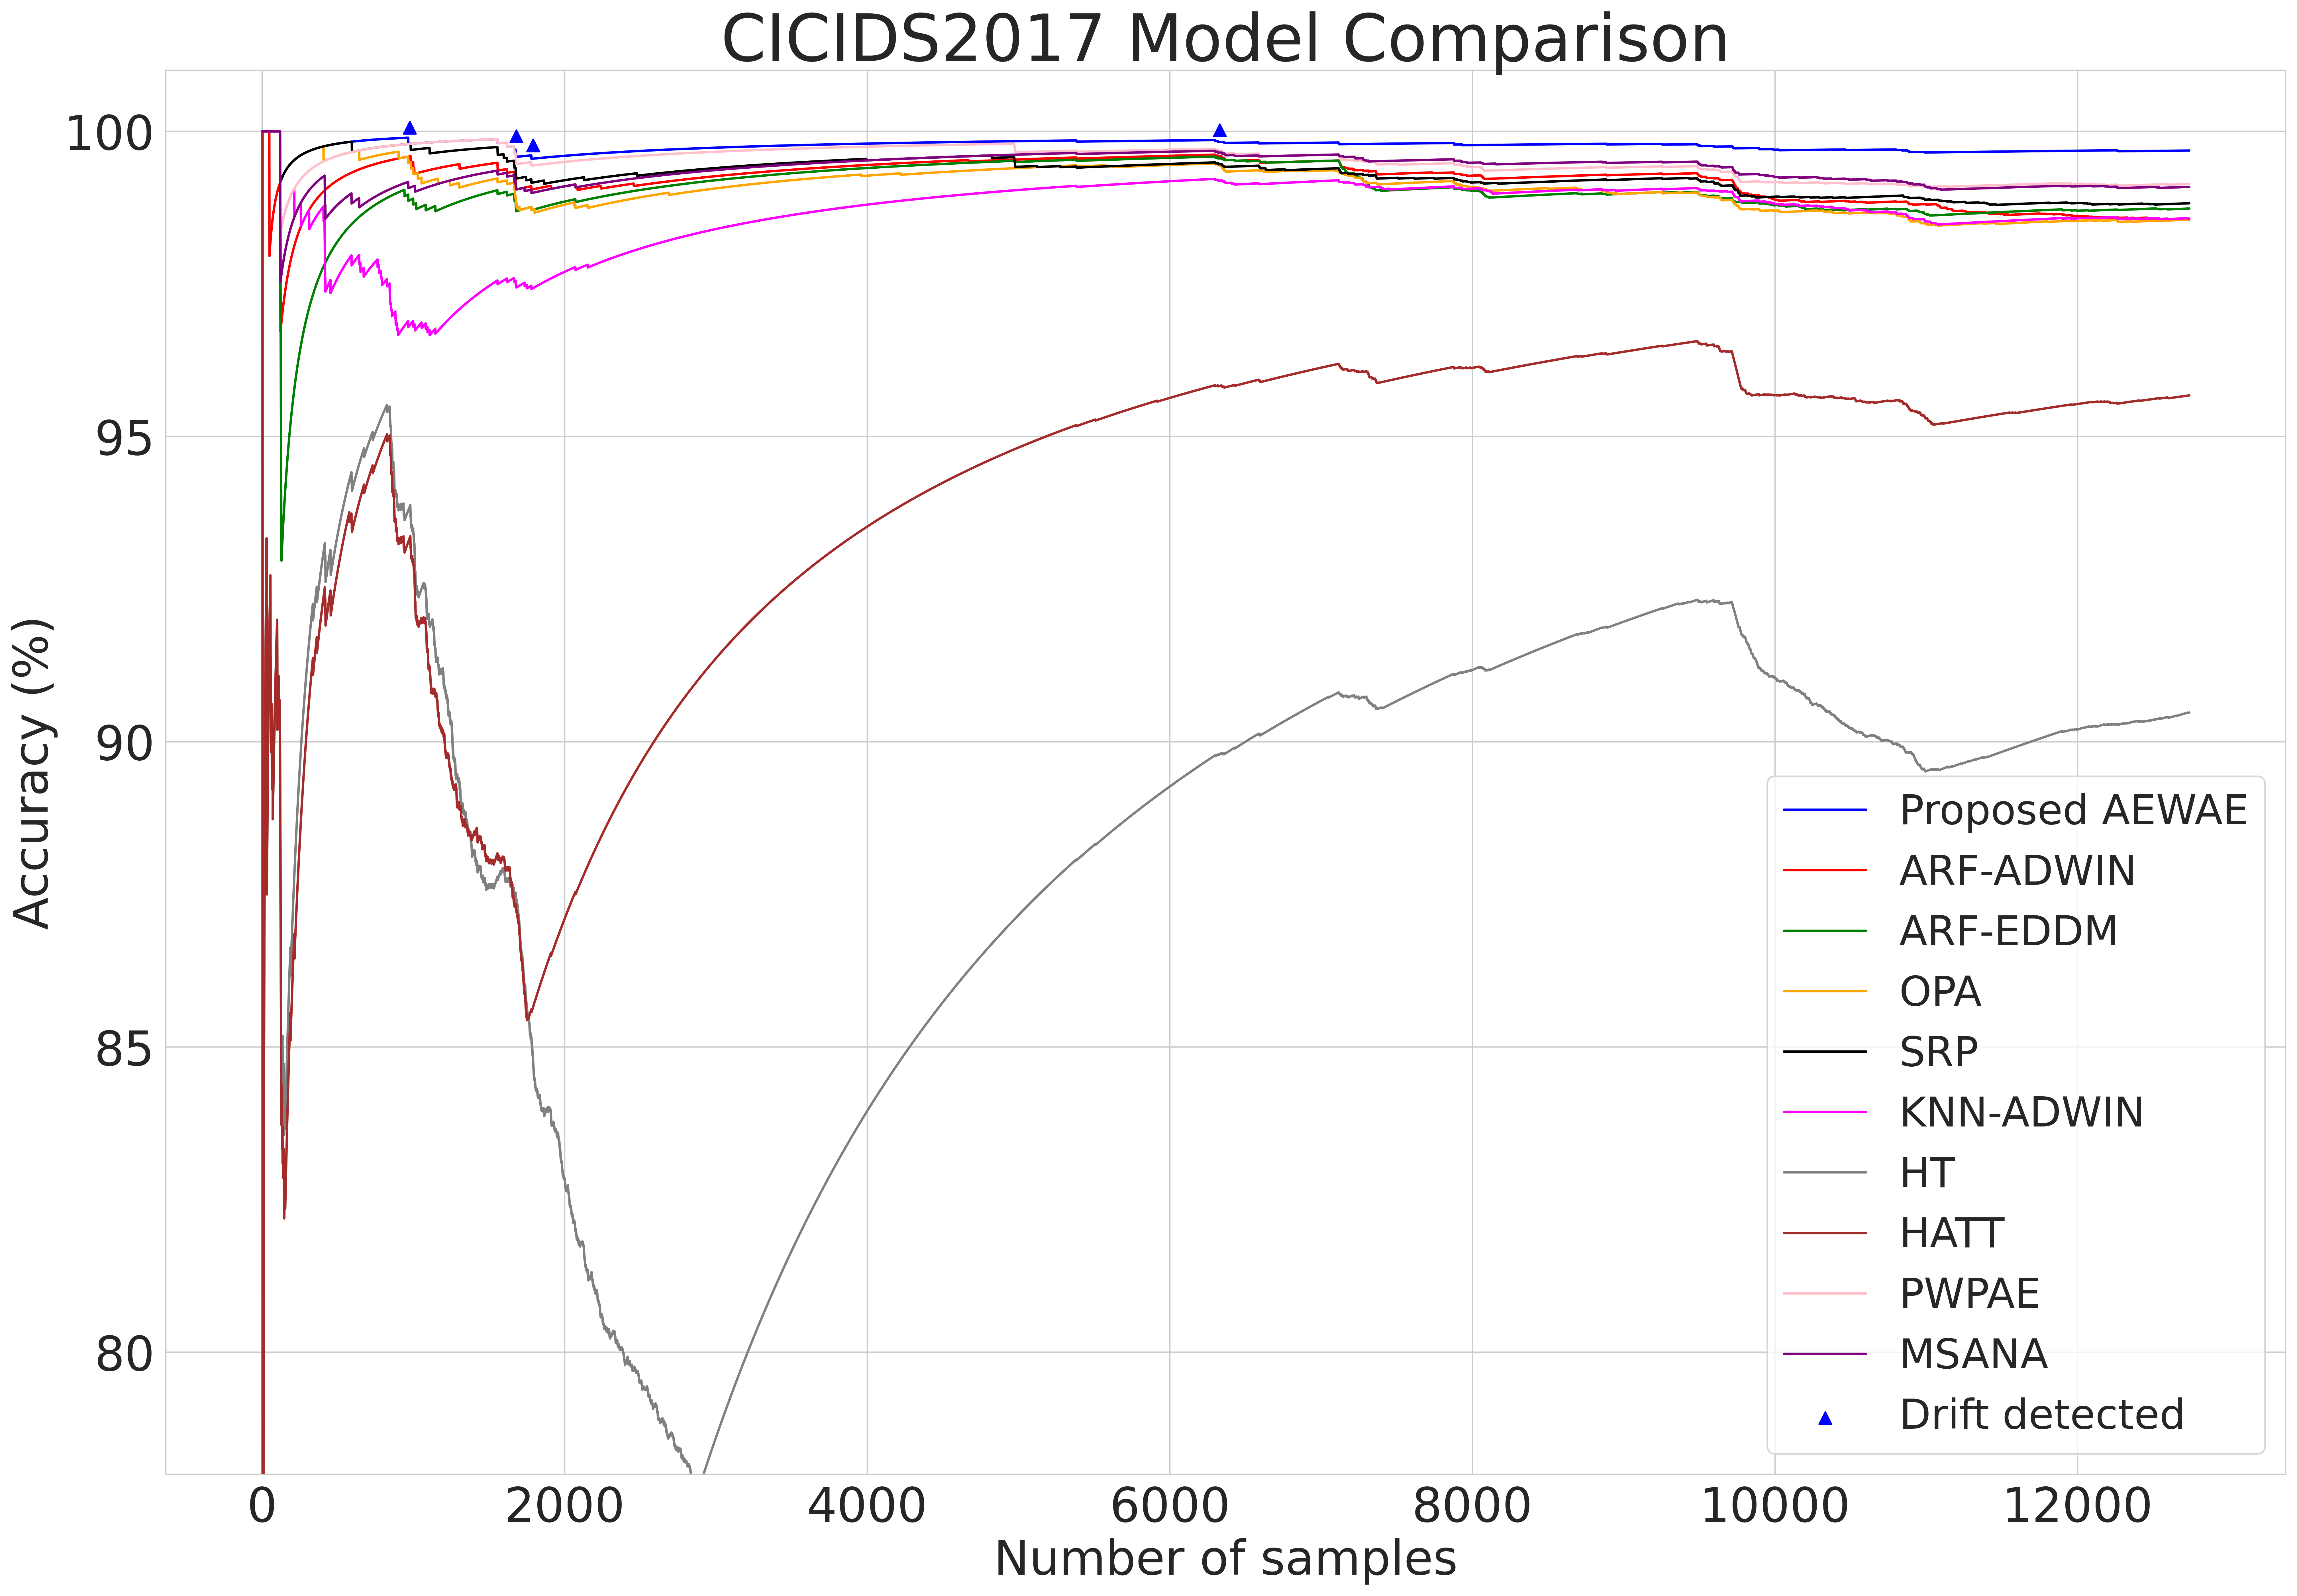

In [ ]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,16), dpi=400)
sns.set_style("whitegrid")
plt.clf()

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name)
# plt.plot(t,m0,'pink',label=name0')
plt.plot(t,m1,'-r',label=name1)
plt.plot(t,m2,'-g',label=name2)
plt.plot(t,m3,'orange',label=name3)
plt.plot(t,m4,'black',label=name4)
plt.plot(t,m5,'magenta',label=name5)
plt.plot(t,m6,'grey',label=name6)
plt.plot(t,m7,'brown',label=name7)
plt.plot(t,m8,'pink',label=name8)
plt.plot(t,m9,'purple',label=name9)

plt.scatter(975, 100.06, marker='^', color='b', s=60, label='Drift detected')
plt.scatter(1680, 99.92, marker='^', color='b', s=60)
plt.scatter(1790, 99.77, marker='^', color='b', s=60)
plt.scatter(6330, 100.02, marker='^', color='b', s=60)

plt.legend(loc='lower right', fontsize=26)
plt.ylim(78, 101)
plt.title('CICIDS2017 Model Comparison', fontsize=41)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.savefig('/content/drive/My Drive/AEWAE/CICIDS2017.eps', format='eps', dpi=400)
plt.draw()

### PDF(Probability Density Function)

In [ ]:
def aewae_pdf(X_train, y_train, X_test, y_test, alpha):
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    cumulative_error1 = 0
    cumulative_error2 = 0
    cumulative_error3 = 0
    cumulative_error4 = 0

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []
    inference_times = []


    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
    hat4 = linear_model.PAClassifier() # OPA

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        start_time = time.time()
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)

        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        error1 = 1 if y_pred1 != yi else 0
        error2 = 1 if y_pred2 != yi else 0
        error3 = 1 if y_pred3 != yi else 0
        error4 = 1 if y_pred4 != yi else 0

        cumulative_error1 = alpha * cumulative_error1 + (1 - alpha) * error1
        cumulative_error2 = alpha * cumulative_error2 + (1 - alpha) * error2
        cumulative_error3 = alpha * cumulative_error3 + (1 - alpha) * error3
        cumulative_error4 = alpha * cumulative_error4 + (1 - alpha) * error4

        ewa_error_rate1 = cumulative_error1 / (1 - alpha ** (i + 1))
        ewa_error_rate2 = cumulative_error2 / (1 - alpha ** (i + 1))
        ewa_error_rate3 = cumulative_error3 / (1 - alpha ** (i + 1))
        ewa_error_rate4 = cumulative_error4 / (1 - alpha ** (i + 1))


        ep = 0.001
        ea = 1 / (ewa_error_rate1 + ep) + 1 / (ewa_error_rate2 + ep) + 1 / (ewa_error_rate3 + ep) + 1 / (
                ewa_error_rate4 + ep)
        w1 = 1 / (ewa_error_rate1 + ep) / ea
        w2 = 1 / (ewa_error_rate2 + ep) / ea
        w3 = 1 / (ewa_error_rate3 + ep) / ea
        w4 = 1 / (ewa_error_rate4 + ep) / ea


        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)


        y_prob_0 = w1 * ypro10 + w2 * ypro20 + w3 * ypro30 + w4 * ypro40
        y_prob_1 = w1 * ypro11 + w2 * ypro21 + w3 * ypro31 + w4 * ypro41

        if y_prob_0 > y_prob_1:
            y_pred = 0
        else:
            y_pred = 1

        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)


        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)

        i = i + 1



    return t, m, yt, yp, inference_times

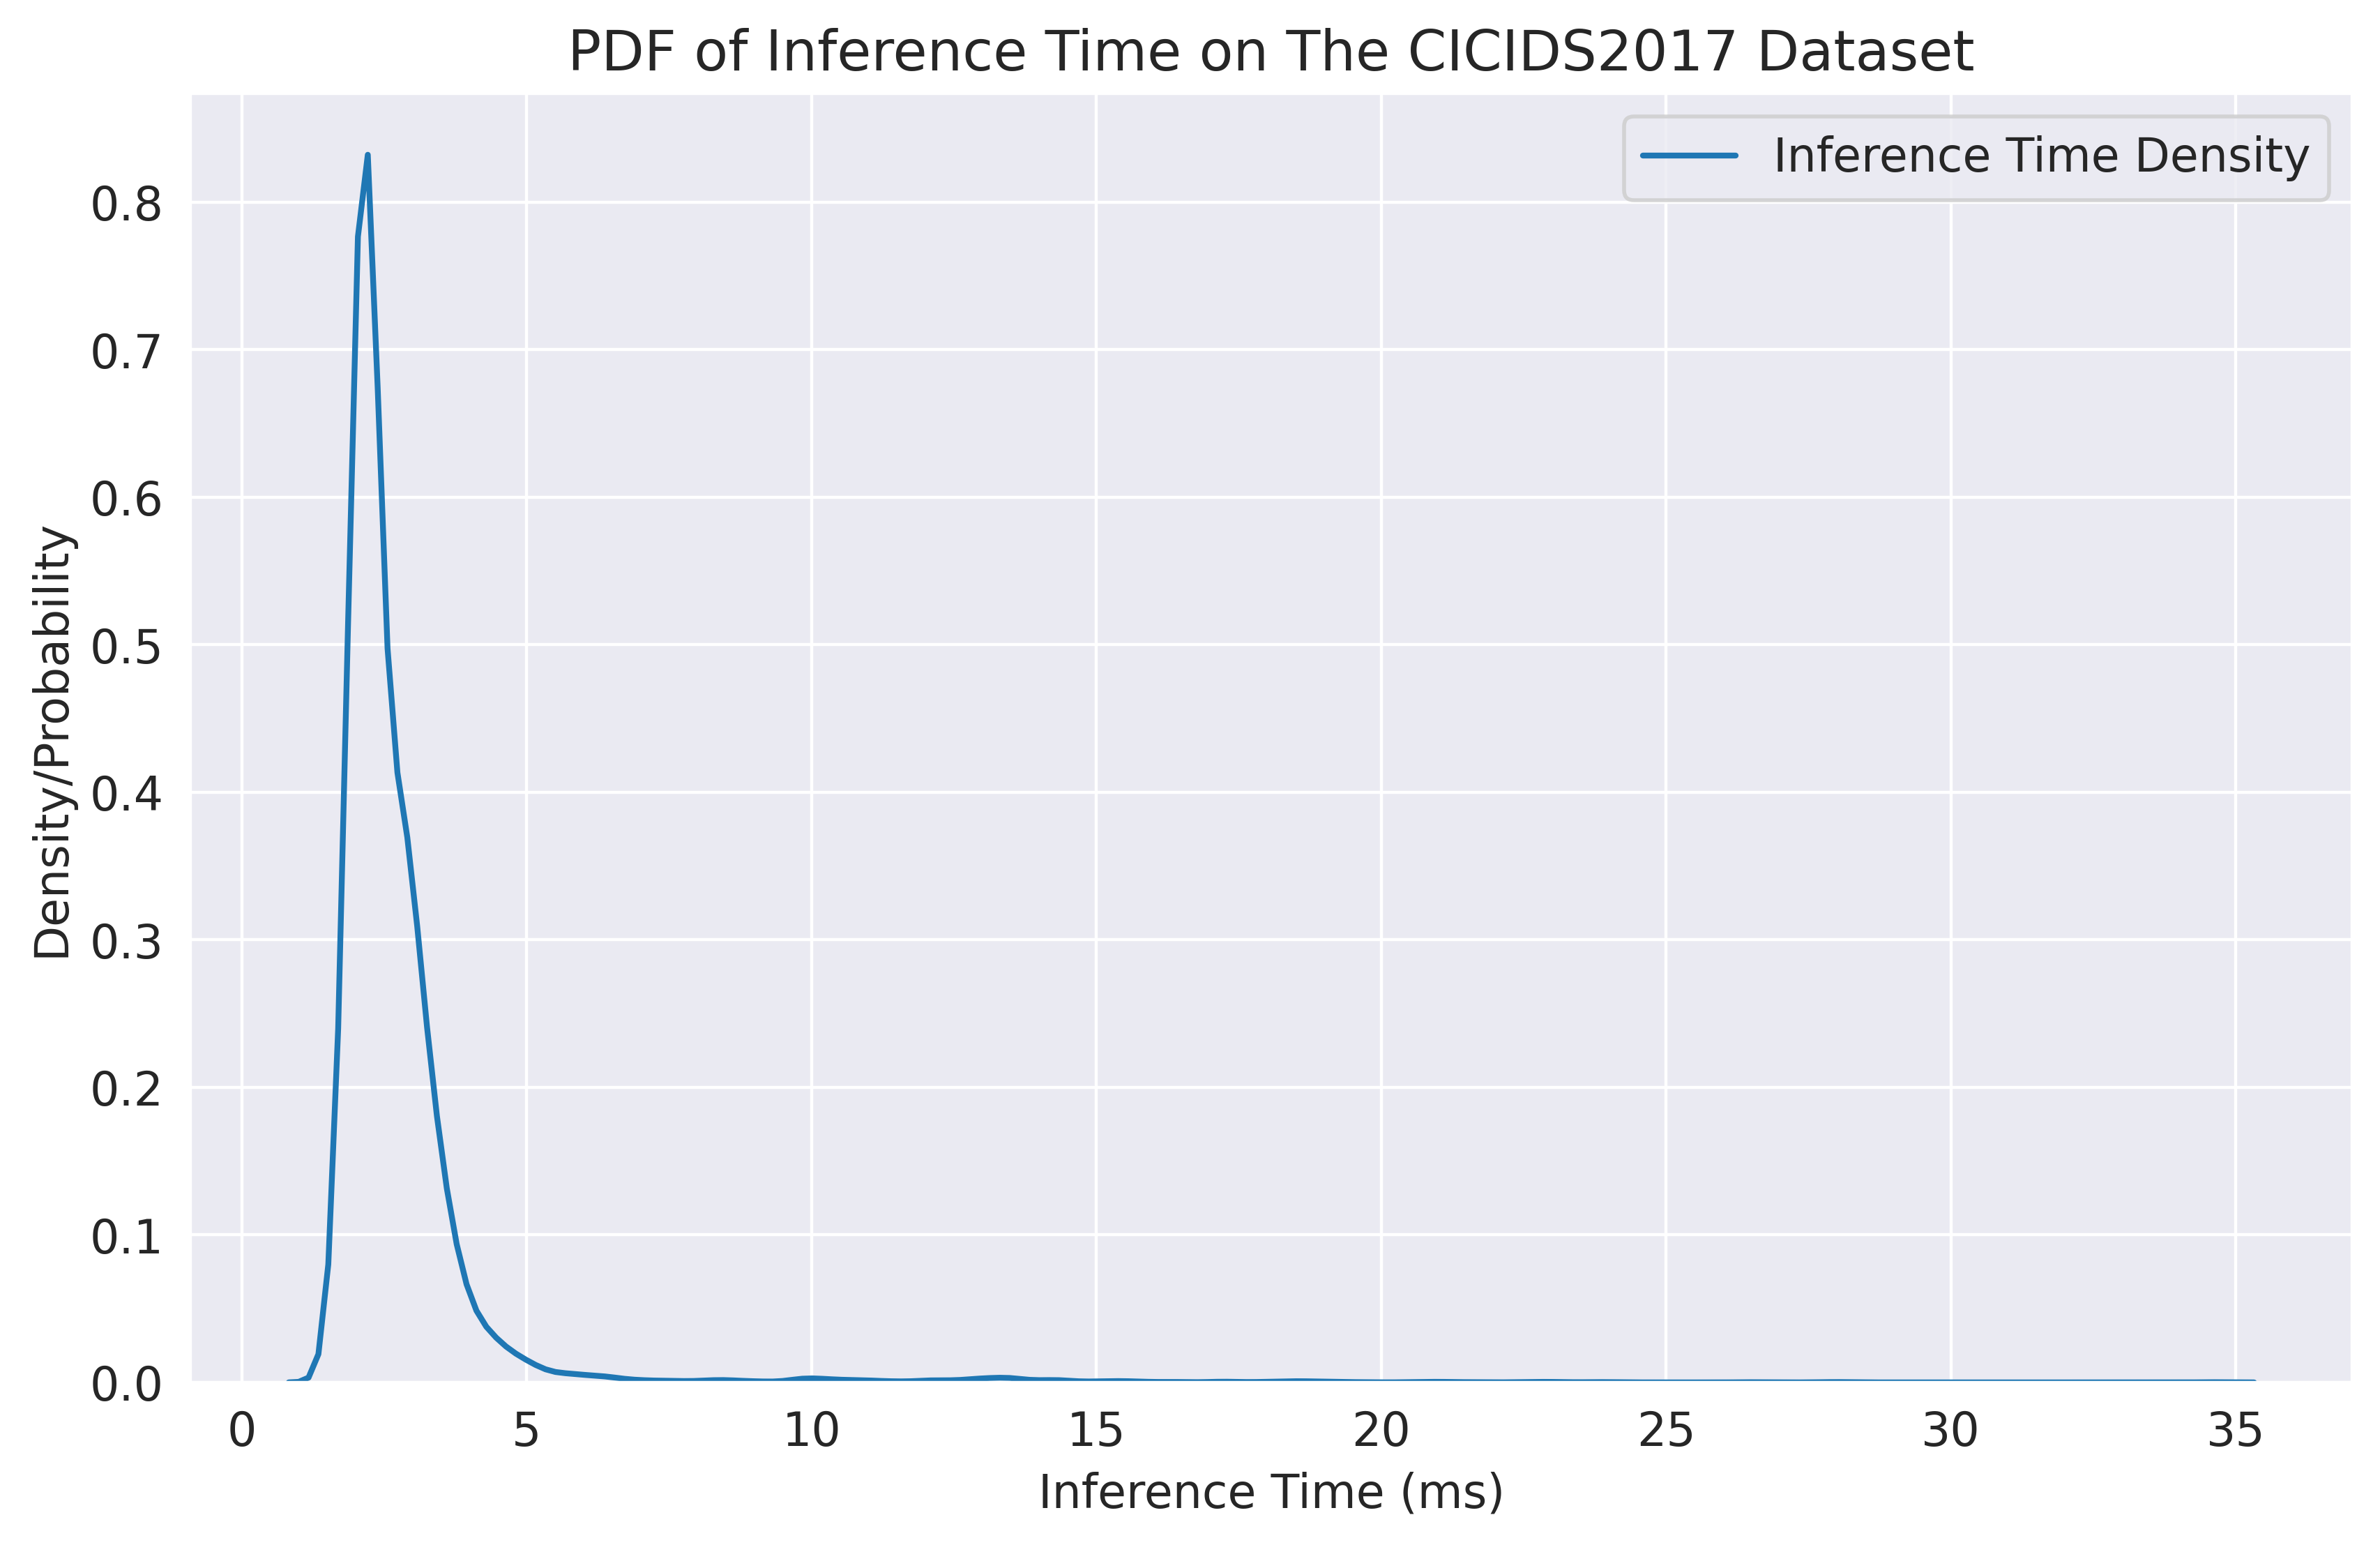

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
# Set the global font size
plt.rcParams.update({'font.size': 12})

# Call the AEWAE function and get the inference times
t, m, yt, yp, inference_times = aewae_pdf(X_train, y_train, X_test, y_test, 0.032490234375)

# Convert inference times from seconds to milliseconds
inference_times_ms = [time * 1000 for time in inference_times]

# Create a figure with a specified size (in inches) and resolution (DPI)
plt.figure(figsize=(10, 6), dpi=400)

# Plot the probability density function for the inference times
sns.kdeplot(inference_times_ms, label='Inference Time Density')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Density/Probability')
plt.title('PDF of Inference Time on The CICIDS2017 Dataset')
plt.legend()
#plt.savefig('/content/drive/My Drive/AEWAE/CICIDS2017_pdf.eps', format='eps', dpi=400)
# Show the plot with the adjusted size, font size, time unit, title, and higher resolution
plt.show()


### CDF(Cumulative Distribution Function)

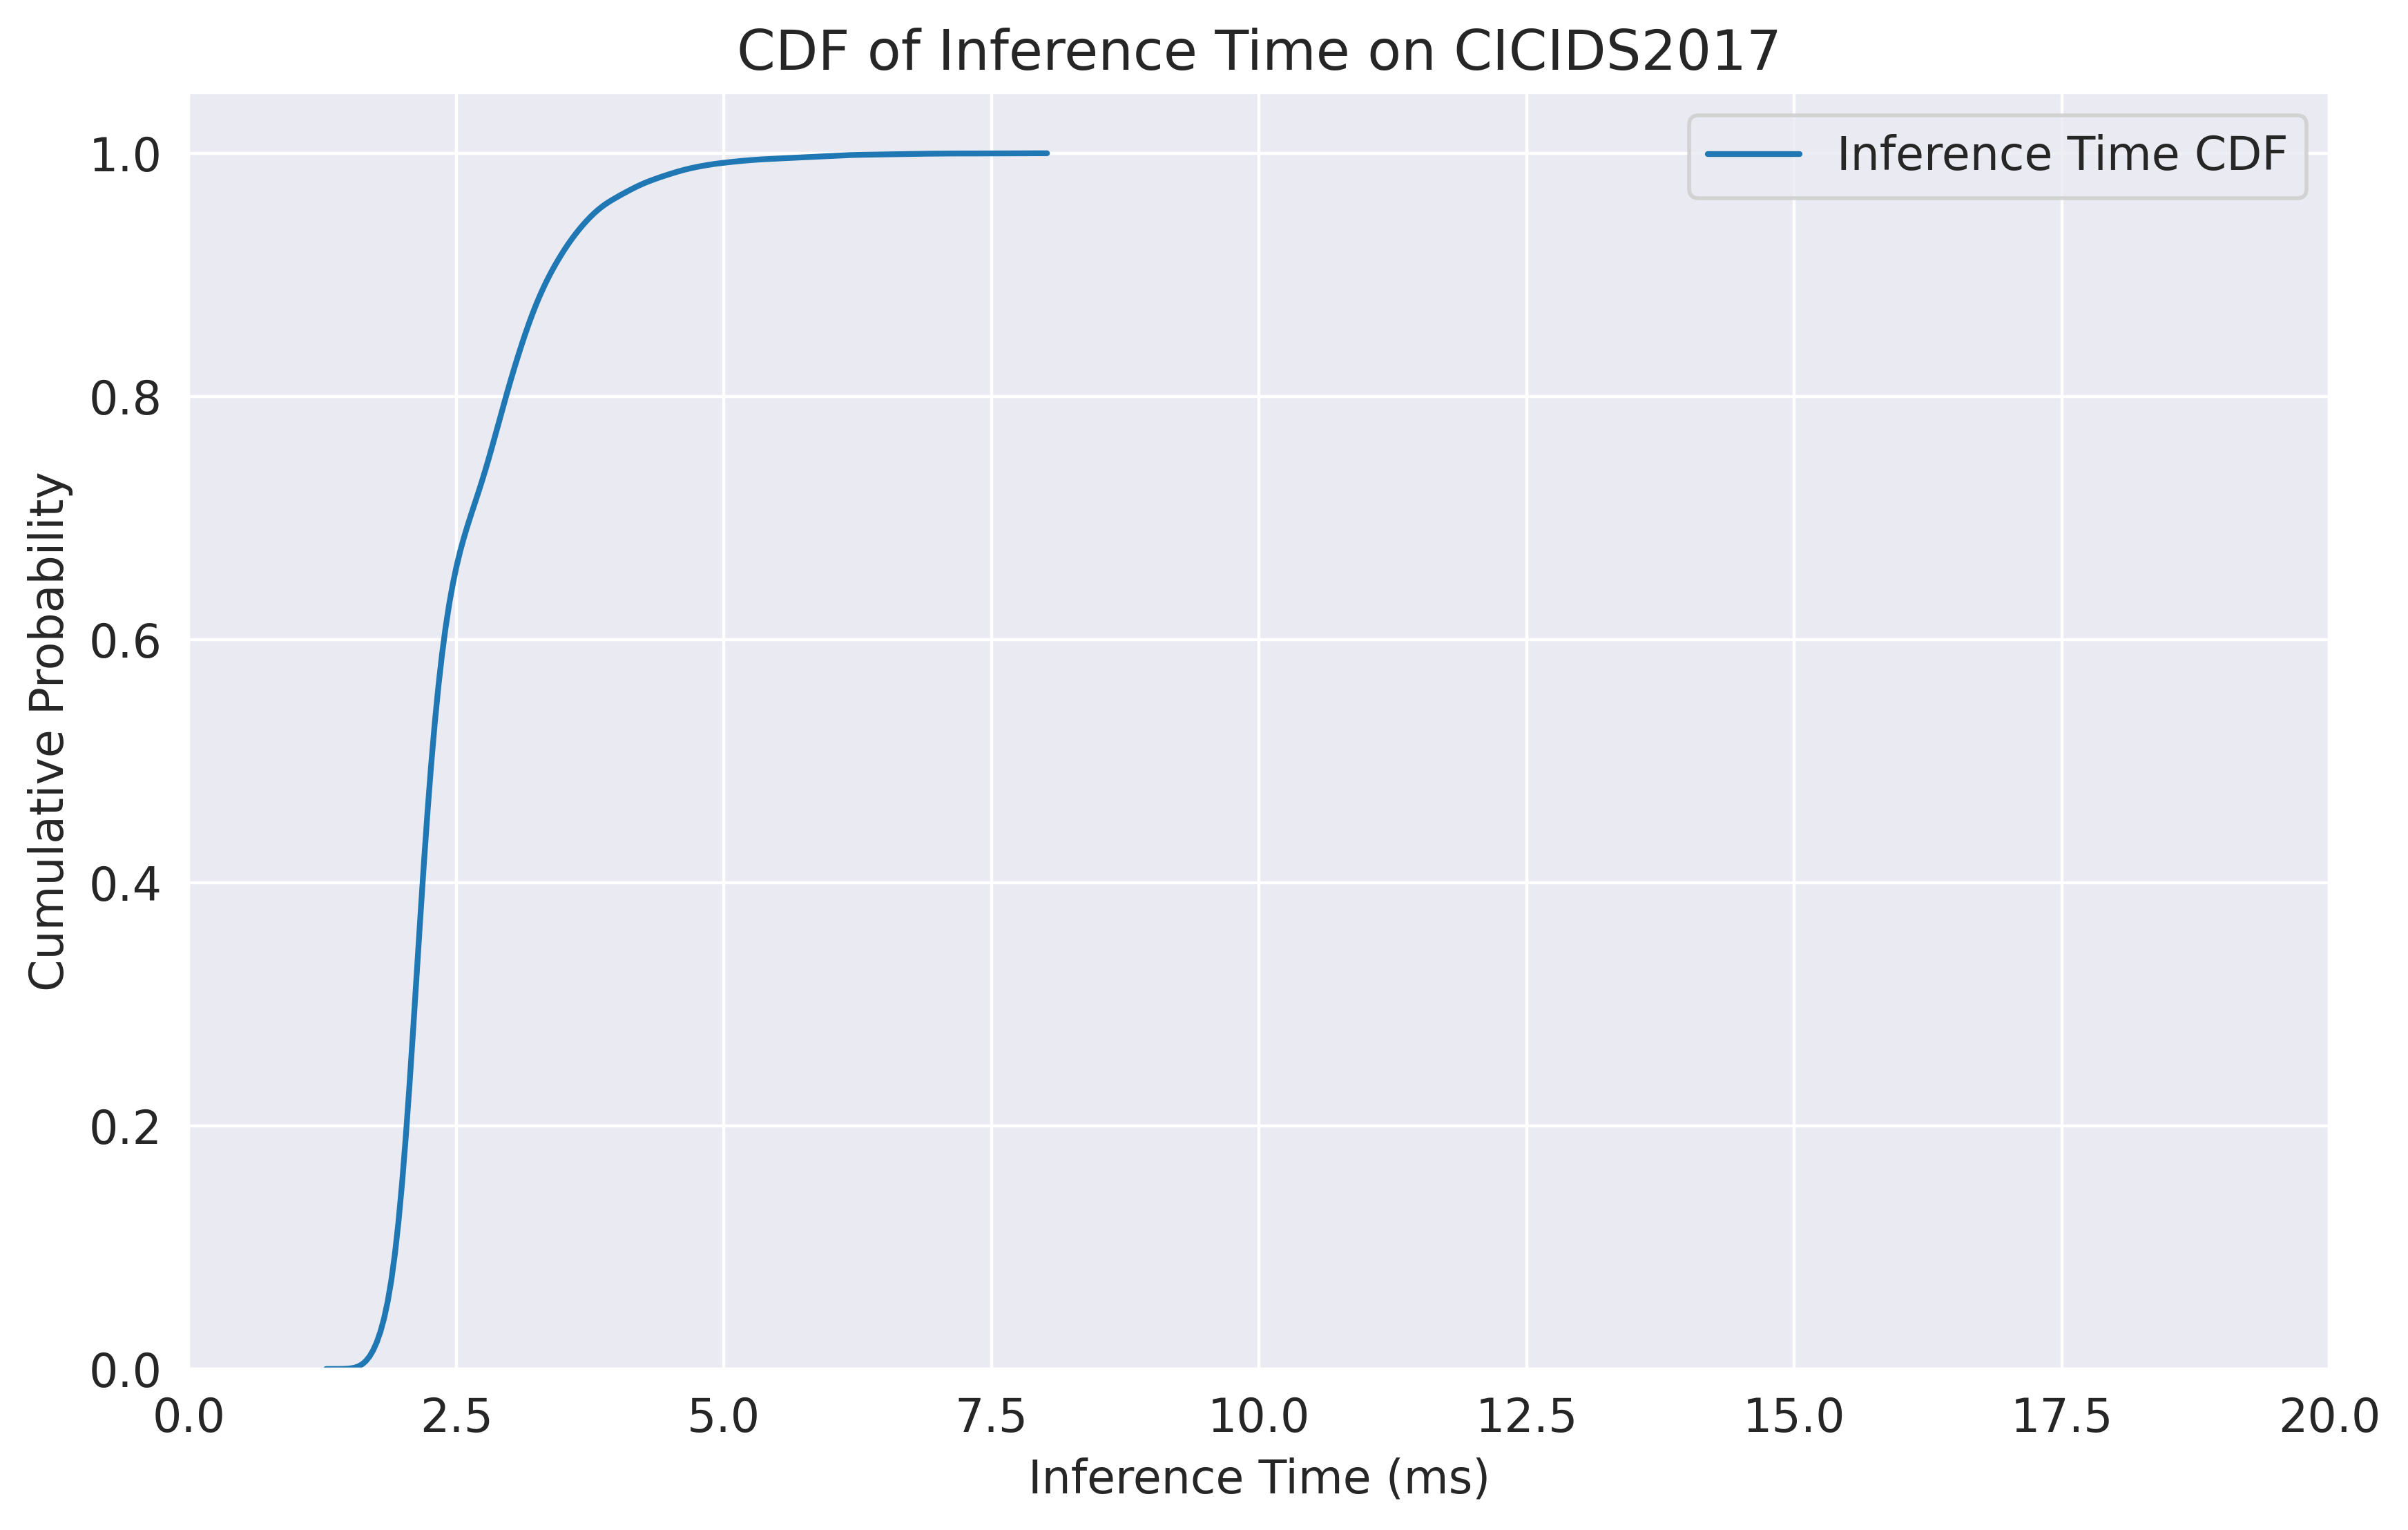

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Continue with the setup as before...
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 12})

# Call the AEWAE function and get the inference times
t, m, yt, yp, inference_times = aewae_pdf(X_train, y_train, X_test, y_test, 0.032490234375)

# Convert inference times from seconds to milliseconds
inference_times_ms = [time * 1000 for time in inference_times]

# Create a figure with a specified size (in inches) and resolution (DPI)
plt.figure(figsize=(10, 6), dpi=400)

# Plot the Cumulative Distribution Function for the inference times
# Note the addition of the `cumulative=True` parameter
sns.kdeplot(inference_times_ms, cumulative=True, label='Inference Time CDF')

plt.xlabel('Inference Time (ms)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Inference Time on CICIDS2017')
plt.legend(loc='upper right')

# Set the x-axis limit to 0-20ms
plt.xlim(0, 20)

plt.savefig('/content/drive/My Drive/AEWAE/CICIDS2017_cdf.eps', format='eps', dpi=400)
# Show the plot with the adjusted size, font size, time unit, title, and higher resolution
plt.show()
